# Model Training and Evaluation

This notebook trains and evaluates machine learning models for gender and age classification using the extracted audio features.

# Import Required Libraries

This cell imports the libraries used the data processing, feature scaling, model training, evaluation, and model persistence.

In [ ]:
# Import libraries for data manipulation and machine learning
import numpy as np
import pandas as pd
import librosa
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn for preprocessing and evaluation metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, recall_score

# TensorFlow and Keras for building and training neural network models
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical

# Joblib for saving and loading models
from joblib import dump, load


# Load Feature Dataset

This cell loads the extracted audio feature dataset from disk and displays the first few rows to verify successful loading.

In [ ]:
# Load dataset from a CSV file
features_path = r"D:/mcv-scripted-en-v23.0/cv-corpus-23.0-2025-09-05/features.csv"
df = pd.read_csv(features_path)

# Display the first few rows of the dataset
df.head()

# Encode Gender Labels

This cell maps textual gender labels to numerical values, removes samples the unmapped labels, and displays the resulting class distribution.

In [ ]:
# Encode Labels (gender)
gender_mapping = {
    "male": 0,
    "male_masculine": 0,
    "female": 1,
    "female_feminine": 1
}

# Map gender labels
df["gender_label"] = df["gender"].map(gender_mapping)
df = df.dropna(subset=["gender_label"])

# Print the distribution of gender labels
df["gender_label"].value_counts()

# Prepare Input Features and Gender Labels

This cell separates MFCC features columns from the encoded gender labels to create input and target arrays for gender classification.

In [ ]:
# Prepare features and labels (gender)
X = df.filter(regex="mfcc_").values
y = df["gender_label"].values

# Split Data into Training and Test Sets (Gender)

This cell splits the gender classification data into training and test sets using stratification to preserve class distribution.

In [ ]:
# Train-test split with stratification to maintain class distribution
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scale Features for Gender Classification

This cell standardises the input features using a training-set-fitted scaler to improve neural network training stability.

In [ ]:
# Scaling the features using StandardScaler for better model performance
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Save the scaler for later use in prediction
dump(scaler, "../models/feature_scaler.joblib")

# Define Gender Classification Model

This cell defines a multi-layer perception architecture for gender classification using fully connected layers and dropout.

In [ ]:
# Create the model (gender)
model = Sequential([
    Dense(64, activation="relu", input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.3),
    Dense(32, activation="relu"),
    Dense(2, activation="softmax")
])

# Compile the model (gender)
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# Print a summary of the model (gender)
model.summary()

# Train Gender Classification Model

This cell trains the neural network on the scaled training data with a validation split to monitor performance and prevent overfitting.

In [ ]:
# Train the model (gender)
history = model.fit(
    X_train_scaled,
    y_train,
    validation_split=0.2,
    epochs=30,
    batch_size=32
)

# Evaluate Gender Classification Model

This cell evaluates the trained model on the test set and displays a classification report with precision, recall, and F1-score metrics for each gender class.

In [118]:
# Evaluate the model (gender)
y_pred_base = np.argmax(model.predict(X_test_scaled), axis=1)

# Print classification report (gender)
print(classification_report(y_test, y_pred_base))

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
              precision    recall  f1-score   support

           0       0.81      0.95      0.87       146
           1       0.75      0.39      0.51        54

    accuracy                           0.80       200
   macro avg       0.78      0.67      0.69       200
weighted avg       0.79      0.80      0.78       200



# Save Gender Classification Model

This cell saves the trained neural network model to disk in Keras format for future use and deployment.

In [ ]:
# Save the model (gender)
model.save("../models/mlp_gender_classification_model.keras")

# Prepare Age Labels for Classification

This cell maps age categories to numeric labels for multi-class classification: teens(0), twnenties(1), thirties/fourties(2), and other ages(3), then remove any missing values.

In [ ]:
# Prepare features and labels (age)
def map_age(age):
    if age in ["teens"]:
        return 0
    elif age in ["twenties"]:
        return 1
    elif age in ["thirties", "fourties"]:
        return 2
    else:
        return 3

# Map age labels
df["age_label"] = df["age"].apply(map_age)
df = df.dropna(subset=["age_label"])

# Split Age Classification Data

This cell extracts MFCC features and age labels, then splits the data into training(80%) and test(20%) sets with stratification to ensure balanced class distribution across both sets.

In [ ]:
# Prepare features and labels (age)
X_age = df.filter(regex="mfcc_").values
y_age = df["age_label"].values

# Train-test split with stratification to maintain class distribution
X_train_a, X_test_a, y_train_a, y_test_a = train_test_split(
    X_age, y_age, test_size=0.2, random_state=42, stratify=y_age
)

# Scale Age Classification Features

This cell standardises the MFCC features using StandardScaler to normalise the data for improved model training then saves the scaler for consistent preprocessing during prediction.

In [ ]:
# Scaling the features using StandardScaler for better model performance (age)
age_scaler = StandardScaler()
X_train_a = age_scaler.fit_transform(X_train_a)
X_test_a = age_scaler.transform(X_test_a)

# Save the scaler for later use in prediction 
dump(age_scaler, "../models/age_feature_scaler.joblib")

# Buiild, Train, and Evaluate Age Classification Model

This cell defines a multi-layer perception for 4-class age classification, trains it for 30 epochs and evalutes performance with a classification report. 

In [ ]:
age_model = Sequential([
    Dense(64, activation="relu", input_shape=(X_train_a.shape[1],)),
    Dropout(0.3),
    Dense(32, activation="relu"),
    Dense(4, activation="softmax")
])

age_model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

age_model.fit(X_train_a, y_train_a, epochs=30, batch_size=32)

y_pred_age = np.argmax(age_model.predict(X_test_a), axis=1)
print(classification_report(y_test_a, y_pred_age))

# Gender Model with Class Weighting

This section retrains the gender classification model using class weights to reduce bias caused by class imbalance.

In [ ]:
# Compute class weights to handle imbalanced classes
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train),
    y=y_train
)

# Create a dictionary mapping class indices to weights
class_weight_dict = dict(enumerate(class_weights))
print("Class weights:", class_weight_dict)

# Create the weighted model
weighted_model = Sequential([
    Dense(64, activation="relu", input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.3),
    Dense(32, activation="relu"),
    Dense(2, activation="softmax")
])

# Compile the weighted model
weighted_model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# Train weighted model
history_weighted = weighted_model.fit(
    X_train_scaled,
    y_train,
    validation_split=0.2,
    epochs=30,
    batch_size=32,
    class_weight=class_weight_dict
)


# Baseline vs Weighted Model Gender Model Evaluation

This section compares the performance of the baseline gender classification model against the class-weighted model using classification reports on the test dataset.

In [119]:
# Baseline model evaluation
y_pred_base = np.argmax(model.predict(X_test_scaled), axis=1)
print("Baseline gender model:")
print(classification_report(y_test, y_pred_base))

# Weighted model evaluation
y_pred_weighted = np.argmax(weighted_model.predict(X_test_scaled), axis=1)
print("Weighted gender model:")
print(classification_report(y_test, y_pred_weighted))


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step 
Baseline gender model:
              precision    recall  f1-score   support

           0       0.81      0.95      0.87       146
           1       0.75      0.39      0.51        54

    accuracy                           0.80       200
   macro avg       0.78      0.67      0.69       200
weighted avg       0.79      0.80      0.78       200

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Weighted gender model:
              precision    recall  f1-score   support

           0       0.89      0.82      0.85       146
           1       0.59      0.72      0.65        54

    accuracy                           0.79       200
   macro avg       0.74      0.77      0.75       200
weighted avg       0.81      0.79      0.80       200



# Save Age Classification Model

Saves the trained age classification model to disk in Keras format for future use.

In [ ]:
# Save the model (age)
age_model.save("../models/mlp_age_merged_classification_model.keras")

# Define MFCC Feature Extraction Function

Extracts 13 MFCC features from an audio file by computing the mean across time frames.

In [ ]:
# MFCC extraction function
def extract_mfcc_from_audio(path, n_mfcc=13):
    audio, sr = librosa.load(path, sr=None)
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)
    return mfcc.mean(axis=1)

# Load Trained Models and Scalers

Loads the saved gender and age classification models long with their respective feature scalers for making predictions.

In [120]:
# Load model and libraries for prediction
gender_model = load_model("../models/mlp_gender_classification_model.keras", compile=False)
age_model = load_model("../models/mlp_age_merged_classification_model.keras", compile=False)

# Load scaler for prediction
scaler = load("../models/feature_scaler.joblib")
age_scaler = load("../models/age_feature_scaler.joblib")

# Check Gender Label Distribution

Displays the proportion of each gender class in the dataset to assess class balance.

In [121]:
df["gender_label"].value_counts(normalize=True)

gender_label
0    0.731
1    0.269
Name: proportion, dtype: float64

# Test Gender Prediction on Sample Data

Selects one male and one female sample from the dataset, runs predictions, and displays true vs predicted gender with confidence probabilities.

In [108]:
# Qualitative inference on dataset samples (no audio playback)

# Select one male-labelled and one female-labelled sample
male_sample = df[df["gender_label"] == 0].sample(1, random_state=10).iloc[0]
female_sample = df[df["gender_label"] == 1].sample(1, random_state=10).iloc[0]

samples = {
    "Male-labelled sample": male_sample,
    "Female-labelled sample": female_sample
}

gender_labels = ["Male", "Female"]

for title, sample in samples.items():
    mfcc = sample[[col for col in df.columns if col.startswith("mfcc")]].values

    pred = gender_model.predict(
        scaler.transform(mfcc.reshape(1, -1))
    )

    print(f"\n--- {title} ---")
    print("True gender:", sample["gender"])
    print("Predicted gender:", gender_labels[np.argmax(pred)])
    probs = pred[0]
    print(f"Probability (Male): {probs[0]:.2f}, (Female): {probs[1]:.2f}")



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step

--- Male-labelled sample ---
True gender: male_masculine
Predicted gender: Male
Probability (Male): 0.96, (Female): 0.04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step

--- Female-labelled sample ---
True gender: female_feminine
Predicted gender: Female
Probability (Male): 0.30, (Female): 0.70


# Generate Model Predictions

This section generates predicted gender labels for the test set using both the baseline and class-weighted models for subsequent evaluation and comparison. 

In [126]:
# Generate predictions from baseline model
y_pred_base = np.argmax(model.predict(X_test_scaled), axis=1)

# Generate predictions from weighted model
y_pred_weighted = np.argmax(weighted_model.predict(X_test_scaled), axis=1)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


# Confusion Matrix Calculation

This section computes matrices for both the baseline and weighted gender classification models to analyse class-specific prediction performance.

In [124]:
# Confusion matrix for both models calculation
cm_base = confusion_matrix(y_test, y_pred_base)
cm_weighted = confusion_matrix(y_test, y_pred_weighted)

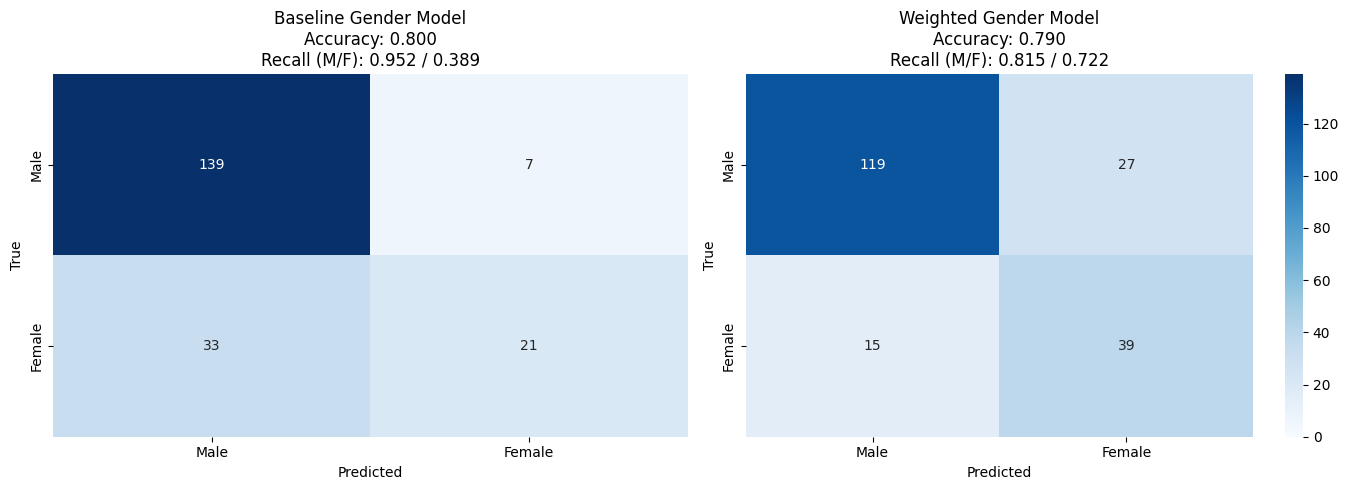

In [ ]:
# Compute evaluation metrics
acc_base = accuracy_score(y_test, y_pred_base)
acc_weighted = accuracy_score(y_test, y_pred_weighted)

recall_base = recall_score(y_test, y_pred_base, average=None)
recall_weighted = recall_score(y_test, y_pred_weighted, average=None)

# Use a shared colour scale for fair comparison
vmax = max(cm_base.max(), cm_weighted.max())

# Plot confusion matrices side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Baseline model confusion matrix
sns.heatmap(
    cm_base,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Male", "Female"],
    yticklabels=["Male", "Female"],
    ax=axes[0],
    vmin=0,
    vmax=vmax,
    cbar=False
)

# Set titles and labels for baseline model
axes[0].set_title(
    f"Baseline Gender Model\n"
    f"Accuracy: {acc_base:.3f}\n"
    f"Recall (M/F): {recall_base[0]:.3f} / {recall_base[1]:.3f}"
)

axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("True")

# Weighted model confusion matrix
sns.heatmap(
    cm_weighted,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Male", "Female"],
    yticklabels=["Male", "Female"],
    ax=axes[1],
    vmin=0,
    vmax=vmax,
    cbar=True
)

# Set titles and labels for weighted model
axes[1].set_title(
    f"Weighted Gender Model\n"
    f"Accuracy: {acc_weighted:.3f}\n"
    f"Recall (M/F): {recall_weighted[0]:.3f} / {recall_weighted[1]:.3f}"
)

axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("True")

# Adjust layout and show plot
plt.tight_layout()
plt.show()


In [117]:
# Test 10 random female samples
female_samples = df[df["gender_label"] == 1].sample(10, random_state=42)

labels = ["Male", "Female"]
correct_count = 0

print("Testing 10 Female Samples:")
print("=" * 70)

for idx, (_, sample) in enumerate(female_samples.iterrows(), 1):
    # Extract MFCC features from dataframe
    mfcc_features = sample[[col for col in df.columns if col.startswith("mfcc_")]].values

    # Predict gender
    gender_probs = weighted_model.predict(
        scaler.transform(mfcc_features.reshape(1, -1)),
        verbose=0
    )

    predicted_class = np.argmax(gender_probs)
    confidence = gender_probs[0][predicted_class]
    is_correct = (predicted_class == 1)

    if is_correct:
        correct_count += 1

    status = "✓" if is_correct else "✗"
    print(
        f"{status} Sample {idx}: "
        f"Predicted {labels[predicted_class]} "
        f"({confidence*100:.1f}% confidence)"
    )

print(f"\n{'=' * 70}")
print(f"Female Recall (sampled): {correct_count}/10 = {correct_count/10:.0%}")
print("Expected from confusion matrix: ~69%")

Testing 10 Female Samples:
✓ Sample 1: Predicted Female (59.2% confidence)
✓ Sample 2: Predicted Female (97.4% confidence)
✓ Sample 3: Predicted Female (69.1% confidence)
✓ Sample 4: Predicted Female (91.9% confidence)
✗ Sample 5: Predicted Male (62.7% confidence)
✓ Sample 6: Predicted Female (70.9% confidence)
✓ Sample 7: Predicted Female (84.8% confidence)
✓ Sample 8: Predicted Female (71.4% confidence)
✓ Sample 9: Predicted Female (56.7% confidence)
✓ Sample 10: Predicted Female (94.6% confidence)

Female Recall (sampled): 9/10 = 90%
Expected from confusion matrix: ~69%


In [115]:
# Test 10 random male samples
male_samples = df[df["gender_label"] == 0].sample(10, random_state=42)

labels = ["Male", "Female"]
correct_count = 0

print("\nTesting 10 Male Samples:")
print("=" * 70)

for idx, (_, sample) in enumerate(male_samples.iterrows(), 1):
    # Extract MFCC from dataframe
    mfcc_features = sample[[col for col in df.columns if col.startswith('mfcc_')]].values
    
    # Predict
    gender_probs = weighted_model.predict(
        scaler.transform(mfcc_features.reshape(1, -1)),
        verbose=0
    )
    
    predicted_class = np.argmax(gender_probs)
    confidence = gender_probs[0][predicted_class]
    is_correct = (predicted_class == 0)
    
    if is_correct:
        correct_count += 1
    
    status = "✓" if is_correct else "✗"
    print(f"{status} Sample {idx}: Predicted {labels[predicted_class]} ({confidence*100:.1f}% conf)")

print(f"\n{'=' * 70}")
print(f"Male Recall (sampled): {correct_count}/10 = {correct_count/10:.0%}")



Testing 10 Male Samples:
✓ Sample 1: Predicted Male (96.0% conf)
✓ Sample 2: Predicted Male (57.7% conf)
✓ Sample 3: Predicted Male (90.7% conf)
✓ Sample 4: Predicted Male (84.6% conf)
✓ Sample 5: Predicted Male (87.7% conf)
✓ Sample 6: Predicted Male (75.3% conf)
✓ Sample 7: Predicted Male (64.1% conf)
✗ Sample 8: Predicted Female (62.6% conf)
✓ Sample 9: Predicted Male (88.1% conf)
✗ Sample 10: Predicted Female (53.4% conf)

Male Recall (sampled): 8/10 = 80%
